# Visualisation of 1D model output

**Date:** 2025-12-01

**Authors:** Damien Bouffard

**Summary:** This notebook provides tools to visualise 1D lake model output (Simstrat-like `T_out.dat`).

## Content:

This notebook helps you create visualizations of lake temperature and water currents. You can:

1. **Plot time series** showing how temperature changes over time at a specific location
2. **Plot temeperature heatmap** plot temperature heatmap (depth vs time)
3. **evaluate climatology** showing how the cross-section changes over time

## Available Functions:

- `plot_temperature_heatmap(df, years=None, ...)` — plot temperature heatmap (depth vs time).
- `plot_temperature_at_depth(df, depth, ...)` — extract and plot a time series at the nearest available depth (with aggregation options).
- `plot_temperature_climatology(df, depth, ...)` — compute and plot daily-of-year climatology (mean, std, min, max) with optional baseline-year overlay.
- `compare_heatmaps(path1, path2, ...)` — load two site outputs and plot their difference heatmap (restricted to shallowest system).
- `plot_two_sites_at_depth(path1, path2, depth, ...)` — extract and plot aligned time series from two sites at a given depth.


## Before You Start:

**No Python knowledge needed!** Just follow these steps:
1. Run each cell in order (click the ▶️ button or press Shift+Enter)
2. Change the values in the examples to customize your visualizations
3. Look for the sections marked "👉 CUSTOMIZE HERE" to modify parameters

**Remaining tasks:** 
- add functions to a python scripts DONE
- save figures and data
- comment the codes for beginners (as in 3D_xxx)



In [ ]:
# import necessary libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta


import json
import requests


from functions_1D import plot_temperature_heatmap, plot_temperature_at_depth, plot_temperature_climatology, compare_heatmaps, plot_two_sites_at_depth

In [9]:
# Load data
path = 'data/Geneva'
# Adjust the path - use the correct relative path from your notebook location
data_path = os.path.join(os.path.dirname(os.getcwd()), path, 'T_out.dat')

df = pd.read_csv(data_path)
df['Datetime'] = pd.Timestamp('1981-01-01') + pd.to_timedelta(df['Datetime'], unit='D')
df.head()

,Datetime,-309.000,-308.000,-307.000,-306.000,-305.000,-304.000,-303.000,-302.000,-301.000,...,-9.000,-8.000,-7.000,-6.000,-5.000,-4.000,-3.000,-2.000,-1.000,-0.000
0,1981-01-02 01:00:02.880000000,4.5000,4.5000,4.5000,4.5000,4.5000,4.5000,4.5000,4.5,4.5,...,5.5154,5.5198,5.5242,5.5286,5.5330,5.5374,5.5418,5.5462,5.5506,5.5539
1,1981-01-02 04:00:02.879999999,4.5001,4.5001,4.5000,4.5000,4.5000,4.5000,4.5000,4.5,4.5,...,5.5152,5.5166,5.5155,5.5143,5.5124,5.5101,5.5072,5.5030,5.4950,5.4820
2,1981-01-02 07:00:02.880000000,4.5003,4.5002,4.5001,4.5001,4.5000,4.5000,4.5000,4.5,4.5,...,5.4946,5.4938,5.4925,5.4908,5.4887,5.4857,5.4826,5.4770,5.4682,5.4536
3,1981-01-02 10:00:02.880000000,4.5004,4.5002,4.5001,4.5001,4.5001,4.5000,4.5000,4.5,4.5,...,5.4727,5.4719,5.4709,5.4697,5.4683,5.4664,5.4640,5.4606,5.4542,5.4468
4,1981-01-02 13:00:02.880000000,4.5004,4.5003,4.5002,4.5001,4.5001,4.5001,4.5001,4.5,4.5,...,5.4658,5.4654,5.4647,5.4639,5.4627,5.4606,5.4584,5.4546,5.4480,5.4373


In [10]:
df.columns

Index(['Datetime', '-309.000', '-308.000', '-307.000', '-306.000', '-305.000',
       '-304.000', '-303.000', '-302.000', '-301.000',
       ...
       '-9.000', '-8.000', '-7.000', '-6.000', '-5.000', '-4.000', '-3.000',
       '-2.000', '-1.000', '-0.000'],
      dtype='object', length=311)

In [ ]:
import pandas as pd
import numpy as np
import json
import requests


def generate_path_API_1D(model, lake, start, stop, variables="T"):
    """
    Generate API path for 1D simulation data.
    
    Parameters:
    -----------
    model : str
        The simulation model (e.g., 'simstrat')
    lake : str
        The lake name (e.g., 'aegeri')
    start : str
        Start datetime in format 'YYYYMMDDHHMM' (e.g., '202405050300')
    stop : str
        Stop datetime in format 'YYYYMMDDHHMM' (e.g., '202406072300')
    variables : str, optional
        Variables to query (default: 'T' for temperature)
    
    Returns:
    --------
    str
        Complete API URL path
    """
    base_url = "https://alplakes-api.eawag.ch/simulations/1d/depthtime"
    return f"{base_url}/{model}/{lake}/{start}/{stop}?variables={variables}"


def read_API_1D_to_dataframe(api_url_or_json_path, variable='T'):
    """
    Read API JSON data and convert to pandas DataFrame with datetime index.
    
    This function reads JSON data from either:
    - A URL (API endpoint)
    - A local JSON file path
    
    The JSON structure should contain:
    - 'time': list of datetime strings
    - 'depth': dict with 'data' (list of depth values), 'unit', 'description'
    - 'variables': dict with variable names as keys (e.g., 'T' for temperature)
      Each variable contains 'data' (2D array), 'unit', 'description'
    
    Parameters:
    -----------
    api_url_or_json_path : str
        Either a URL to the API endpoint or a path to a local JSON file
    variable : str, optional
        Variable name to extract (default: 'T' for temperature)
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with:
        - First column: 'Datetime' (timezone-naive datetime64[ns])
        - Remaining columns: Depth values (e.g., '-81.000' to '-0.000')
        - Values: Temperature or other variable data
        
    Note: Datetime values are converted to timezone-naive for better compatibility
          with numpy and most pandas operations.
    
    Example:
    --------
    >>> # From API
    >>> url = generate_path_API_1D('simstrat', 'aegeri', '202405050300', '202406072300')
    >>> df = read_API_1D_to_dataframe(url)
    >>> print(df.columns)
    Index(['Datetime', '-81.000', '-80.000', ..., '-1.000', '-0.000'], dtype='object')
    
    >>> # From local file
    >>> df = read_API_1D_to_dataframe('ttt.json')
    """
    
    # Load JSON data
    if api_url_or_json_path.startswith('http'):
        # Fetch from API with timeout
        try:
            response = requests.get(api_url_or_json_path, timeout=300)  # 5 minute timeout
            response.raise_for_status()
            data = response.json()
        except requests.exceptions.Timeout:
            raise TimeoutError(
                "API request timed out. The date range might be too large. "
                "Try requesting smaller time periods (e.g., one year at a time)."
            )
        except requests.exceptions.HTTPError as e:
            if e.response.status_code == 504:
                raise TimeoutError(
                    f"API gateway timeout (504). The date range is too large. "
                    f"Try requesting smaller time periods (e.g., one year at a time) or use fetch_API_1D_chunked()."
                )
            else:
                raise
    else:
        # Load from local file
        with open(api_url_or_json_path, 'r') as f:
            data = json.load(f)
    
    # Extract time, depth, and variable data
    time = data['time']
    depth_values = data['depth']['data']
    variable_data = data['variables'][variable]['data']
    
    # Convert depth values to negative (representing depth below surface)
    # Format with 3 decimal places
    depth_values_negative = [f"{-d:.3f}" for d in depth_values]
    
    # The API returns data as [depth x time], we need [time x depth]
    # So we need to transpose the data
    variable_data_transposed = np.array(variable_data).T
    
    # Create DataFrame
    # Rows = time points, Columns = depth values (negative, 3 decimals)
    df = pd.DataFrame(variable_data_transposed, columns=depth_values_negative)
    
    # Convert time strings to datetime and remove timezone (convert to naive datetime)
    datetime_series = pd.to_datetime(time).tz_localize(None)
    
    # Add Datetime as a column (not index)
    df.insert(0, 'Datetime', datetime_series)
    
    return df


def fetch_API_1D_chunked(model, lake, start, stop, variables="T", chunk_months=12, save_csv=None):
    """
    Fetch large date ranges from API in smaller chunks and combine them.
    
    This function automatically splits large date ranges into smaller chunks
    to avoid API timeouts.
    
    Parameters:
    -----------
    model : str
        The simulation model (e.g., 'simstrat')
    lake : str
        The lake name (e.g., 'geneva')
    start : str
        Start datetime in format 'YYYYMMDDHHMM' (e.g., '198101010000')
    stop : str
        Stop datetime in format 'YYYYMMDDHHMM' (e.g., '202406072300')
    variables : str, optional
        Variables to query (default: 'T' for temperature)
    chunk_months : int, optional
        Number of months per chunk (default: 12 for yearly chunks)
    save_csv : str, optional
        Path to save the resulting DataFrame as CSV (default: None, no save)
        Example: 'output.csv' or '/path/to/file.csv'
    
    Returns:
    --------
    pd.DataFrame
        Combined DataFrame with all data
    
    Example:
    --------
    >>> # Fetch 43 years of data in yearly chunks
    >>> df = fetch_API_1D_chunked('simstrat', 'geneva', '198101010000', '202406072300')
    
    >>> # Fetch and save to CSV
    >>> df = fetch_API_1D_chunked('simstrat', 'geneva', '198101010000', '202406072300', 
    ...                            save_csv='geneva_1981_2024.csv')
    """
    from datetime import datetime, timedelta
    from dateutil.relativedelta import relativedelta
    
    # Parse start and stop dates
    start_dt = datetime.strptime(start, '%Y%m%d%H%M')
    stop_dt = datetime.strptime(stop, '%Y%m%d%H%M')
    
    dfs = []
    current_start = start_dt
    
    print(f"Fetching data from {start_dt} to {stop_dt} in {chunk_months}-month chunks...")
    
    chunk_count = 0
    while current_start < stop_dt:
        # Calculate chunk end (either chunk_months ahead or final stop date)
        current_stop = min(
            current_start + relativedelta(months=chunk_months),
            stop_dt
        )
        
        # Format dates back to API format
        chunk_start_str = current_start.strftime('%Y%m%d%H%M')
        chunk_stop_str = current_stop.strftime('%Y%m%d%H%M')
        
        # Generate URL and fetch
        url = generate_path_API_1D(model, lake, chunk_start_str, chunk_stop_str, variables)
        
        chunk_count += 1
        print(f"  Chunk {chunk_count}: {current_start.date()} to {current_stop.date()}...", end=' ')
        
        try:
            df_chunk = read_API_1D_to_dataframe(url, variable=variables)
            dfs.append(df_chunk)
            print(f"✓ ({len(df_chunk)} rows)")
        except Exception as e:
            print(f"✗ Error: {e}")
            # Continue with next chunk even if this one fails
        
        # Move to next chunk
        current_start = current_stop
    
    if not dfs:
        raise ValueError("No data was successfully fetched")
    
    # Combine all chunks
    print(f"\nCombining {len(dfs)} chunks...")
    df_combined = pd.concat(dfs, axis=0, ignore_index=True)
    
    # Remove any duplicate timestamps (at chunk boundaries)
    df_combined = df_combined.drop_duplicates(subset=['Datetime'], keep='first')
    
    # Reset index after dropping duplicates
    df_combined = df_combined.reset_index(drop=True)
    
    print(f"✓ Total: {len(df_combined)} rows")
    
    # Save to CSV if requested
    if save_csv:
        print(f"\nSaving to CSV: {save_csv}...")
        df_combined.to_csv(save_csv, index=False)
        print(f"✓ Saved successfully")
    
    return df_combined


    
    # Example 2: Fetch small date range from API (commented out - requires network access)
    # print("\n\nExample 2: Fetching small date range from API...")
    # url = generate_path_API_1D('simstrat', 'aegeri', '202405050300', '202406072300')
    # print(f"API URL: {url}")
    # df_api = read_API_1D_to_dataframe(url)
    # print(df_api.head())
    
    # Example 3: Fetch large date range in chunks (commented out - requires network access)
    # print("\n\nExample 3: Fetching large date range in yearly chunks...")
    # df_large = fetch_API_1D_chunked('simstrat', 'geneva', '202001010000', '202406072300', chunk_months=6)
    # print(df_large.head())
    # print(df_large.tail())

In [20]:
# Example usage
url = fetch_API_1D_chunked(
    model='simstrat',
    lake='geneva',
    start='198101010000',
    stop='199006072300'
)
print(url)


Fetching data from 1981-01-01 00:00:00 to 1990-06-07 23:00:00 in 12-month chunks...
  Chunk 1: 1981-01-01 to 1982-01-01... ✓ (2920 rows)
  Chunk 2: 1982-01-01 to 1983-01-01... ✓ (2920 rows)
  Chunk 2: 1982-01-01 to 1983-01-01... ✓ (2920 rows)
  Chunk 3: 1983-01-01 to 1984-01-01... ✓ (2920 rows)
  Chunk 3: 1983-01-01 to 1984-01-01... ✓ (2920 rows)
  Chunk 4: 1984-01-01 to 1985-01-01... ✓ (2920 rows)
  Chunk 4: 1984-01-01 to 1985-01-01... ✓ (2928 rows)
  Chunk 5: 1985-01-01 to 1986-01-01... ✓ (2928 rows)
  Chunk 5: 1985-01-01 to 1986-01-01... ✓ (2920 rows)
  Chunk 6: 1986-01-01 to 1987-01-01... ✓ (2920 rows)
  Chunk 6: 1986-01-01 to 1987-01-01... ✓ (2920 rows)
  Chunk 7: 1987-01-01 to 1988-01-01... ✓ (2920 rows)
  Chunk 7: 1987-01-01 to 1988-01-01... ✓ (2920 rows)
  Chunk 8: 1988-01-01 to 1989-01-01... ✓ (2920 rows)
  Chunk 8: 1988-01-01 to 1989-01-01... ✓ (2928 rows)
  Chunk 9: 1989-01-01 to 1990-01-01... ✓ (2928 rows)
  Chunk 9: 1989-01-01 to 1990-01-01... ✓ (2920 rows)
  Chunk 10: 199

In [ ]:
# Example usage
url = generate_path_API_1D(
    model='simstrat',
    lake='geneva',
    start='198101010000',
    stop='202406072300'
)
print(url)

<Axes: title={'center': 'Temperature  (1982-01-01 to 1989-12-31)'}, xlabel='Date', ylabel='Depth (m)'>

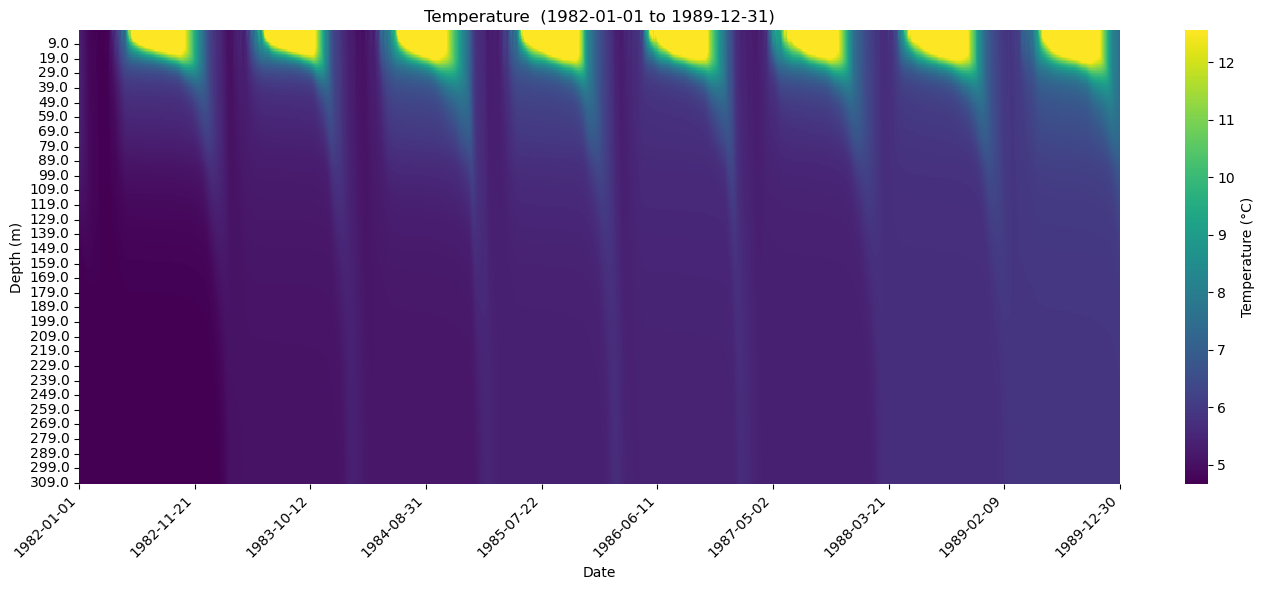

In [22]:
# Example usage (uncomment to run):
#plot_temperature_heatmap(df)                       # plot all data
# plot_temperature_heatmap(df, years=2024)           # single year
plot_temperature_heatmap(url, years=(1982,1989))    # time period from 2020 to 2022

<Axes: title={'center': 'Temperature  (1982-01-01 to 1989-12-31)'}, xlabel='Date', ylabel='Depth (m)'>

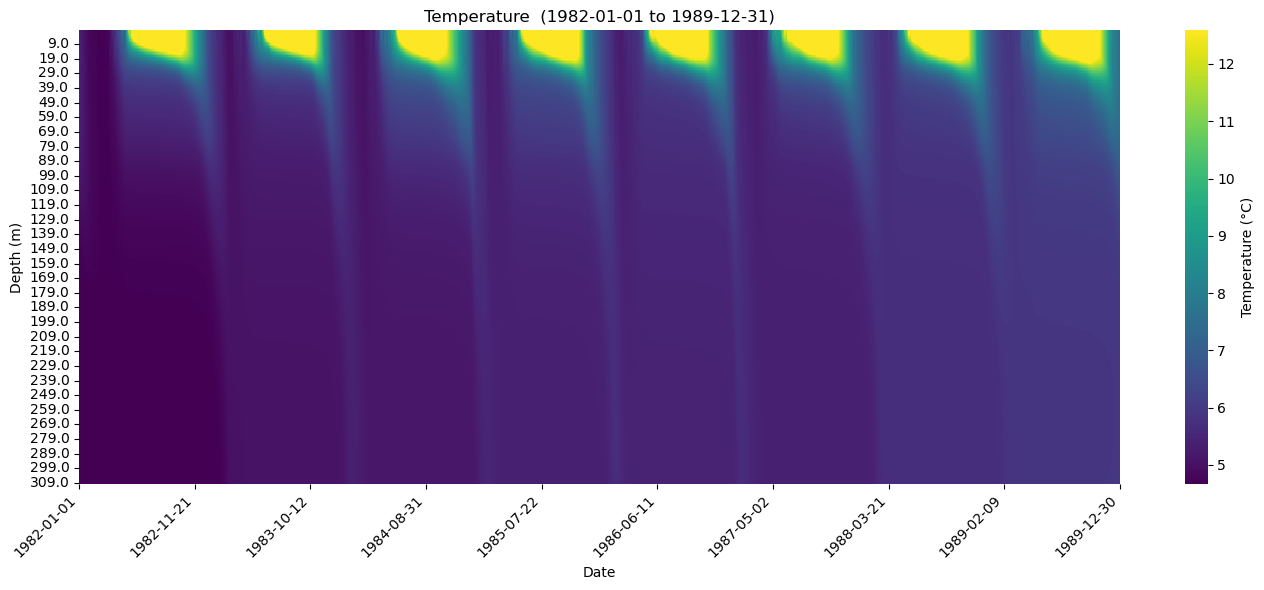

In [23]:
plot_temperature_heatmap(df, years=(1982,1989))    # time period from 2020 to 2022

/Users/bouffada/Documents/Git/Peak_alplakes/scripts/functions_1D.py:162: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  ts_agg = ts.resample(freq).mean()


<Axes: title={'center': 'Temperature at depth ~0.0 m'}, xlabel='Date', ylabel='Temperature (°C)'>

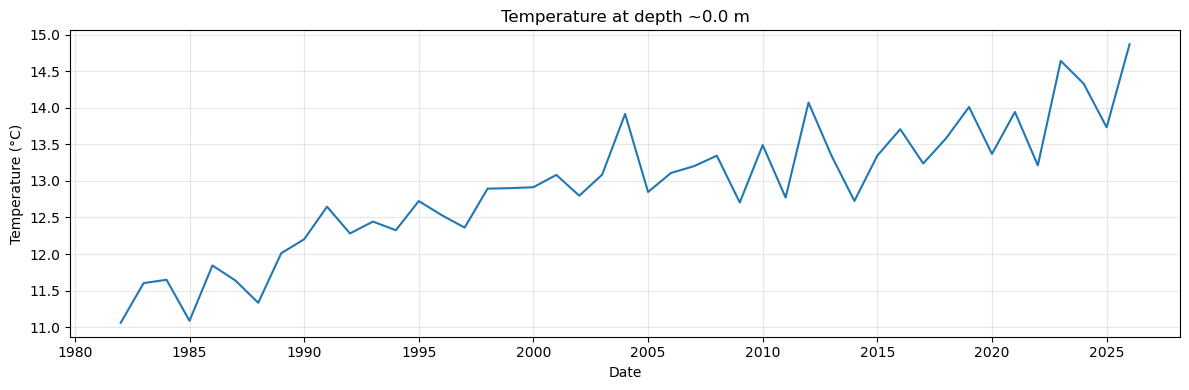

In [4]:
# Example usage:
# plot_temperature_at_depth(df, depth=1.0, agg='daily')
plot_temperature_at_depth(df, depth=0, agg='yearly', method='mean')

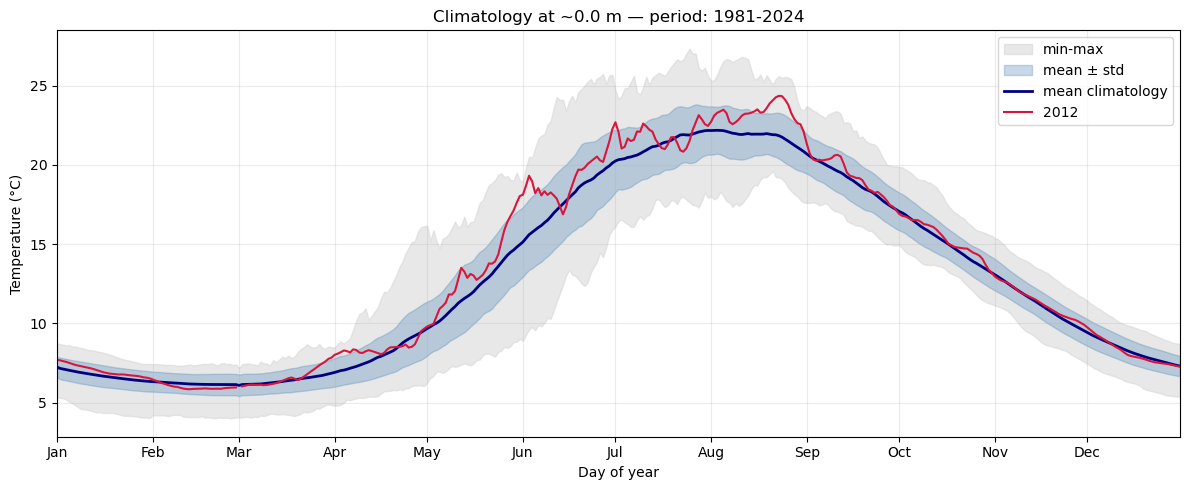

In [5]:
# Example usage:
ax, clim = plot_temperature_climatology(df, depth=0, period=(1981,2024), baseline_year=2012, method='mean')

(<Axes: title={'center': 'Difference heatmap: data/Geneva minus data/Upper_Lugano (depths ≤ 287.0 m)'}, xlabel='Date', ylabel='Depth (m)'>,
 Datetime    1981-01-02 01:00:02.880000000  1981-01-02 04:00:02.879999999  \
 Depth_plot                                                                 
 0.0                                   0.0                         0.0046   
 1.0                                   0.0                         0.0089   
 2.0                                   0.0                         0.0118   
 3.0                                   0.0                         0.0133   
 4.0                                   0.0                         0.0144   
 ...                                   ...                            ...   
 283.0                                 0.0                         0.0000   
 284.0                                 0.0                         0.0000   
 285.0                                 0.0                         0.0000   
 286.0       

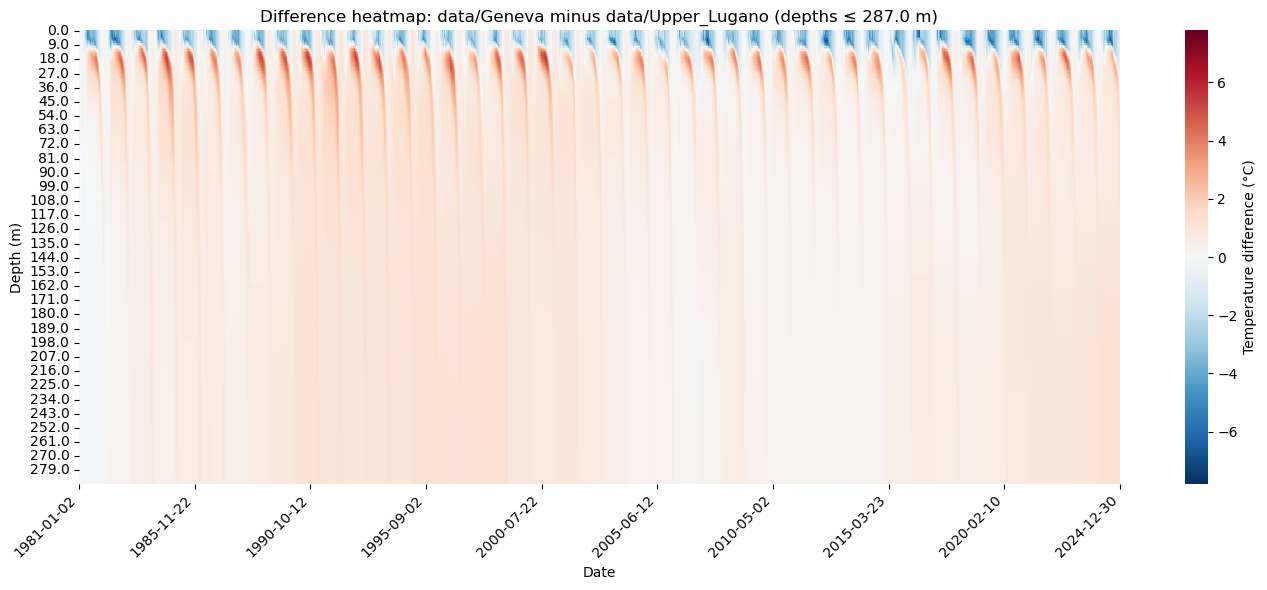

In [6]:
compare_heatmaps('data/Geneva', 'data/Upper_Lugano', years=(1981, 2024))         # single year

/Users/bouffada/Documents/Git/Peak_alplakes/scripts/functions_1D.py:478: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  s1 = s1.resample(freq).mean()
/Users/bouffada/Documents/Git/Peak_alplakes/scripts/functions_1D.py:479: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  s2 = s2.resample(freq).mean()


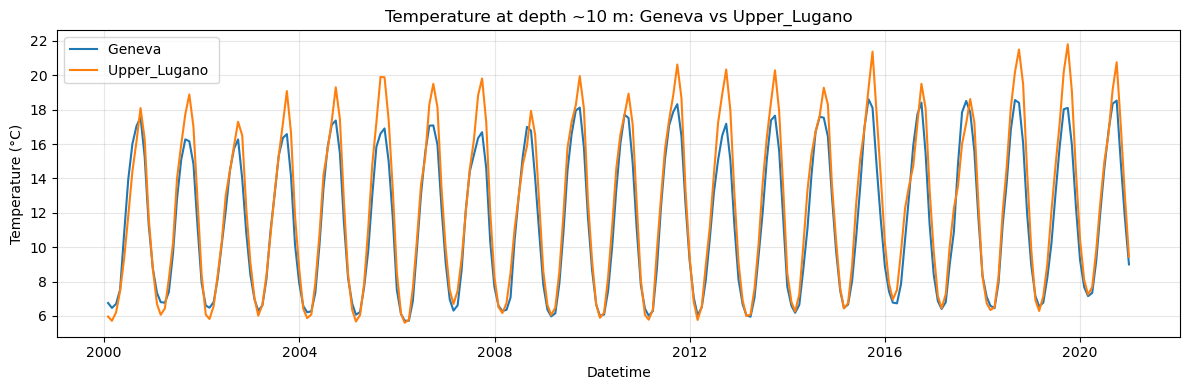

In [7]:
# Example usage:
ax, df = plot_two_sites_at_depth('data/Geneva', 'data/Upper_Lugano', depth=10, years=(2000,2020), agg='monthly', savepath='figures/compare_10m.png')